In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pyiron import Project

In [3]:
data_pr = Project("import_database")

In [4]:
data_pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,21,finished,None,df1_A1_A2_A3_EV_elast_phon,/df1_A1_A2_A3_EV_elast_phon,/home/yury/pyiron/projects/,pyiron-2021/import_database/Cu_database/,2021-02-08 10:33:52.341472,None,None,zora@cmti001#1,GenericJob,0.4,None,None
1,22,finished,None,df3_10k,/df3_10k,/home/yury/pyiron/projects/,pyiron-2021/import_database/Cu_database/,2021-02-08 10:33:53.993230,None,None,zora@cmti001#1,GenericJob,0.4,None,None
2,23,finished,None,df2_1k,/df2_1k,/home/yury/pyiron/projects/,pyiron-2021/import_database/Cu_database/,2021-02-08 10:33:54.435308,None,None,zora@cmti001#1,GenericJob,0.4,None,None


In [5]:
data_job = data_pr.load('df1_A1_A2_A3_EV_elast_phon')

# Fitting project

In [6]:
from pyiron_gpl.pacemaker.pacemaker import PaceMakerJob

In [7]:
fit_pr = Project("pacemaker_fit")

In [65]:
#fit_pr.remove_jobs_silently()#

In [66]:
job = fit_pr.create_job(job_type=PaceMakerJob, job_name="df1_cut5")

## Fit

In [67]:
cutoff = 5.0

In [68]:
job.input["potential"]= {
    "deltaSplineBins": 0.001,
    "element": "Cu",
    "fs_parameters": [1, 1, 1, 0.5],
    "npot": "FinnisSinclairShiftedScaled",
    "NameOfCutoffFunction": "cos",
    "rankmax": 3,
    "nradmax": [15,2,1],
    "lmax": [0,2,1],
    "ndensity": 2,
    "rcut": 5,
    "dcut": 0.01,
    "radparameters": [5.25],
    "radbase": "ChebExpCos",
}

In [69]:
job.input["fit"]= {    
    'optimizer': 'BFGS', 
    'maxiter': 250,
    'loss': {
        'kappa': 0.5,
        'L1_coeffs': 5e-10,
        'L2_coeffs': 5e-10,
        'w1_coeffs': 1,
        'w2_coeffs': 1,
        'w0_rad': 1e-7,
        'w1_rad': 1e-7,
        'w2_rad': 1e-7,
    },
}

In [70]:
job.input["cutoff"] = cutoff
job.input["backend"]["batch_size"] = 1000

In [71]:
job.structure_data=data_job

In [72]:
job.input

,Parameter,Value,Comment
0,cutoff,5.0,
1,metadata,{},
2,data,{},
3,potential,"{'deltaSplineBins': 0.001, 'element': 'Cu', 'fs_parameters': [1, 1, 1, 0.5], 'npot': 'FinnisSinclairShiftedScaled', 'NameOfCutoffFunction': 'cos', 'rankmax': 3, 'nradmax': [15, 2, 1], 'lmax': [0, ...",
4,fit,"{'optimizer': 'BFGS', 'maxiter': 250, 'loss': {'kappa': 0.5, 'L1_coeffs': 5e-10, 'L2_coeffs': 5e-10, 'w1_coeffs': 1, 'w2_coeffs': 1, 'w0_rad': 1e-07, 'w1_rad': 1e-07, 'w2_rad': 1e-07}}",
5,backend,"{'evaluator': 'tensorpot', 'batch_size': 1000}",


In [73]:
job.executable.available_versions

['tf', 'tf_cpu']

In [74]:
job.executable="tf_cpu"

In [ ]:
job.run(run_mode = "non_modal")

In [78]:
fit_pr.job_table(full_table=True)

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,80,finished,None,df1_cut5,/df1_cut5,/home/yury/pyiron/projects/,pyiron-2021/pacemaker_fit/,2021-02-26 12:53:21.925140,2021-02-26 12:54:34.625621,72.0,pyiron@dell-inspiron#1,PaceMakerJob,0.1,None,None


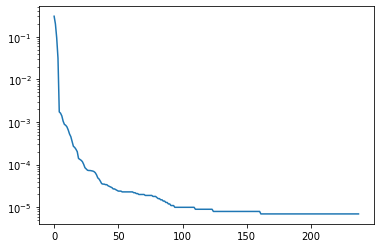

In [79]:
plt.plot(job["output/log/loss"])
plt.yscale('log')

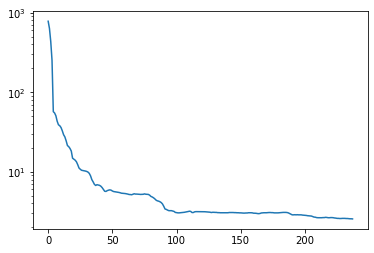

In [80]:
plt.plot(job["output/log/rmse_energy"])
plt.yscale('log')

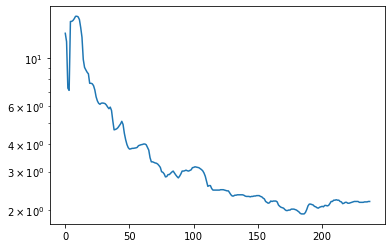

In [81]:
plt.plot(job["output/log/rmse_forces"])
plt.yscale('log')

In [82]:
job.get_final_potential_filename()

'/home/yury/pyiron/projects/pyiron-2021/pacemaker_fit/df1_cut5_hdf5/df1_cut5/df1_cut5.yaml'

In [83]:
job.get_final_potential_filename_ace()

'/home/yury/pyiron/projects/pyiron-2021/pacemaker_fit/df1_cut5_hdf5/df1_cut5/df1_cut5.ace'

# Overview of the fitted potential internals

In [146]:
final_potential = job.get_final_potential()

In [147]:
Cu_block = final_potential.funcspecs_blocks[0]

List of B-basis functions and corresponding fitted coefficients (for two densities):

In [149]:
Cu_block.funcspecs

[BBasisFunctionSpecification(elements=[Al,Al],  ns=[1],  ls=[0],  coeffs=[-0.132635,-0.00889706]),
 BBasisFunctionSpecification(elements=[Al,Al],  ns=[2],  ls=[0],  coeffs=[0.021831,0.00781152]),
 BBasisFunctionSpecification(elements=[Al,Al],  ns=[3],  ls=[0],  coeffs=[0.0694975,0.0255755]),
 BBasisFunctionSpecification(elements=[Al,Al],  ns=[4],  ls=[0],  coeffs=[0.100878,0.039435]),
 BBasisFunctionSpecification(elements=[Al,Al],  ns=[5],  ls=[0],  coeffs=[0.0784641,0.0366628]),
 BBasisFunctionSpecification(elements=[Al,Al],  ns=[6],  ls=[0],  coeffs=[-0.00303997,0.0145095]),
 BBasisFunctionSpecification(elements=[Al,Al],  ns=[7],  ls=[0],  coeffs=[-0.107938,-0.0167209]),
 BBasisFunctionSpecification(elements=[Al,Al],  ns=[8],  ls=[0],  coeffs=[-0.178038,-0.0387258]),
 BBasisFunctionSpecification(elements=[Al,Al],  ns=[9],  ls=[0],  coeffs=[-0.168335,-0.036112]),
 BBasisFunctionSpecification(elements=[Al,Al],  ns=[10],  ls=[0],  coeffs=[-0.0807872,-0.00726093]),
 BBasisFunctionSpecifi

# Test fitted potential

In [84]:
test_pr = Project("test_ace_potential")

In [85]:
cu_ace_potential = job.get_lammps_potential()

## Optimization

In [86]:
lammps_job = test_pr.create.job.Lammps("opt_lammps", delete_existing_job=True)

In [87]:
lammps_job.executable.version="2020.12.24_pace"

In [88]:
lammps_job.potential = cu_ace_potential

In [89]:
lammps_job.structure = test_pr.create.structure.ase_bulk("Cu","fcc",cubic=True)

In [90]:
lammps_job.calc_minimize(pressure=0.0)

In [91]:
lammps_job.run()

The job opt_lammps was saved and received the ID: 81


## Elastic matrix

In [111]:
elmat_job = test_pr.create.job.ElasticMatrixJob("elmat")

In [112]:
ref_job = test_pr.create.job.Lammps("ref_job", delete_existing_job=True)

In [113]:
ref_job.executable.version="2020.12.24_pace"

In [114]:
#ref_job.calc_static()

In [115]:
ref_job.potential = cu_ace_potential

In [116]:
ref_job.structure = lammps_job.get_structure()

In [117]:
ref_job.server.run_mode="non_modal"

In [118]:
elmat_job.ref_job = ref_job

In [ ]:
elmat_job.run(run_mode="non_modal", run_again=True)

In [139]:
test_pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,81,finished,Cu4,opt_lammps,/opt_lammps,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/,2021-02-26 12:54:46.117385,2021-02-26 12:54:46.617448,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,NaN
1,82,finished,Cu4,phon_job,/phon_job,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/,2021-02-26 12:54:58.745687,2021-02-26 12:55:13.747981,15.0,pyiron@dell-inspiron#1#1/1,PhonopyJob,0.0.1,None,NaN
2,83,finished,Cu108,ref_job_0,/ref_job_0,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/phon_job_hdf5/,2021-02-26 12:55:11.351661,2021-02-26 12:55:11.862122,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,82.0
3,84,finished,Cu4,elmat,/elmat,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/,2021-02-26 12:57:05.499830,2021-02-26 12:58:28.890465,83.0,pyiron@dell-inspiron#1#1/13,ElasticMatrixJob,0.0.1,None,NaN
4,85,finished,Cu4,s_e_0,/s_e_0,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 12:57:09.134167,2021-02-26 12:57:09.656789,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,84.0
5,86,finished,Cu4,s_01_e_m0_00500,/s_01_e_m0_00500,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 12:57:14.089914,2021-02-26 12:57:14.722149,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,84.0
6,87,finished,Cu4,s_01_e_m0_00250,/s_01_e_m0_00250,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 12:57:18.778998,2021-02-26 12:57:19.251781,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,84.0
7,88,finished,Cu4,s_01_e_0_00250,/s_01_e_0_00250,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 12:57:23.312311,2021-02-26 12:57:23.914459,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,84.0
8,89,finished,Cu4,s_01_e_0_00500,/s_01_e_0_00500,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 12:57:29.045891,2021-02-26 12:57:29.597258,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,84.0
9,90,finished,Cu4,s_08_e_m0_00500,/s_08_e_m0_00500,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 12:57:35.593480,2021-02-26 12:57:36.263261,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,84.0


In [140]:
elmat_job["output/elasticmatrix"]["C"]

array([[185.94676377, 120.73237664, 120.73237664,   0.        ,
          0.        ,   0.        ],
       [120.73237664, 185.94676377, 120.73237664,   0.        ,
          0.        ,   0.        ],
       [120.73237664, 120.73237664, 185.94676377,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  78.34168019,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         78.34168019,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  78.34168019]])

## Phonons

In [100]:
phon_job = test_pr.create.job.PhonopyJob("phon_job", delete_existing_job=True)

In [101]:
ref_job = test_pr.create.job.Lammps("ref_job", delete_existing_job=True)

In [102]:
ref_job.executable.version="2020.12.24_pace"

In [103]:
ref_job.calc_static()

In [104]:
ref_job.potential = cu_ace_potential

In [105]:
ref_job.structure = lammps_job.get_structure()

In [106]:
phon_job.ref_job = ref_job

In [ ]:
phon_job.run(run_mode="non_modal")

In [122]:
test_pr.job_table(full_table=True)

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,64,finished,Cu4,elmat,/elmat,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/,2021-02-26 12:50:04.490993,2021-02-26 12:51:24.937689,80.0,pyiron@dell-inspiron#1#1/13,ElasticMatrixJob,0.0.1,None,NaN
1,65,finished,Cu4,s_e_0,/s_e_0,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 12:50:08.150673,2021-02-26 12:50:08.670702,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0
2,66,finished,Cu4,s_01_e_m0_00500,/s_01_e_m0_00500,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 12:50:13.073071,2021-02-26 12:50:13.600686,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0
3,67,finished,Cu4,s_01_e_m0_00250,/s_01_e_m0_00250,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 12:50:17.795531,2021-02-26 12:50:18.350906,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0
4,68,finished,Cu4,s_01_e_0_00250,/s_01_e_0_00250,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 12:50:22.684634,2021-02-26 12:50:23.240086,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0
5,69,finished,Cu4,s_01_e_0_00500,/s_01_e_0_00500,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 12:50:27.896122,2021-02-26 12:50:28.480391,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0
6,70,finished,Cu4,s_08_e_m0_00500,/s_08_e_m0_00500,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 12:50:33.162833,2021-02-26 12:50:33.698030,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0
7,71,finished,Cu4,s_08_e_m0_00250,/s_08_e_m0_00250,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 12:50:39.052056,2021-02-26 12:50:39.605935,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0
8,72,finished,Cu4,s_08_e_0_00250,/s_08_e_0_00250,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 12:50:45.441164,2021-02-26 12:50:46.030061,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0
9,73,finished,Cu4,s_08_e_0_00500,/s_08_e_0_00500,/home/yury/pyiron/projects/,pyiron-2021/test_ace_potential/elmat_hdf5/,2021-02-26 12:50:52.363621,2021-02-26 12:50:53.040951,0.0,pyiron@dell-inspiron#1,Lammps,0.1,None,64.0


<AxesSubplot:title={'center':'Phonon DOS vs Energy'}, xlabel='Frequency [THz]', ylabel='DOS'>

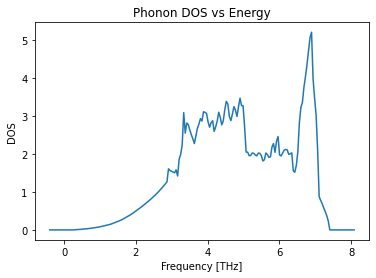

In [110]:
phon_job.plot_dos()